# Rasterio Input/Output Review
__Using the popular rasterio library__

- Read in the raster files
- View metadata
- Read raster to a numpy array
- Plot seperate bands
- Save bands to a geotiff file

In [2]:
import os
import rasterio
import matplotlib.pyplot as plt
from rasterio import plot
%matplotlib inline

## Opening Raster Files
- Rasterio’s open( ) function takes a path string or path-like object and returns an opened dataset object

In [3]:
# Get the file path and file name for red, green, and blue bands
image_path = './data/L8_20200613_hudsonRiver/'
band4_fn = 'LC08_L1TP_013031_20200613_20200625_01_T1_sr_band4.tif' # red band file name
band3_fn = 'LC08_L1TP_013031_20200613_20200625_01_T1_sr_band3.tif' # green band file name
band2_fn = 'LC08_L1TP_013031_20200613_20200625_01_T1_sr_band2.tif' # blue band file name
band5_fn = 'LC08_L1TP_013031_20200613_20200625_01_T1_sr_band5.tif' # NIR band file name

# Use rasterio.open to open each image and read
band4 = rasterio.open(image_path + band4_fn, driver="GTiff") # red band
band3 = rasterio.open(image_path + band3_fn, driver="GTiff") # green band
band2 = rasterio.open(image_path + band2_fn, driver="GTiff") # blue band
band5 = rasterio.open(image_path + band5_fn, driver="GTiff") # NIR band

## View Raster Metadata
- View image band count and size
- View band data types
- View the coordinate reference system

In [4]:
# Explore the raster image band count and image size (dimensions)
print(band4.count) # rasters can have more than one band, like an RGB raster file
print(band4.height)
print(band4.width)

1
7771
7641


In [16]:
# View some other metadata information attached to the bands
band4.dtypes

'int16'

In [17]:
# View the coordinate reference system for the raster
band4.crs

CRS.from_epsg(32618)

In [19]:
# View the transform parameters
# used for converting a matrix array into a raster (which is a georeference array with other metadata)
band4.transform

Affine(30.0, 0.0, 563385.0,
       0.0, -30.0, 4741215.0)

In [13]:
band4.bounds

BoundingBox(left=563385.0, bottom=4508085.0, right=792615.0, top=4741215.0)

## Reading Raster Data to Numpy Array
- The read( ) method returns and N-D numpy array. The index starts at 1

In [ ]:
# Read the band into a matrix (2d-array)
# Use this to get bands into a matrix to utilize in matplotlib and other libraries for processing,
# anaysis, and visualization.
# Dont forget to transform the matrix to get it back into a coordinate system!
band4.read(1)

## Visualize the bands

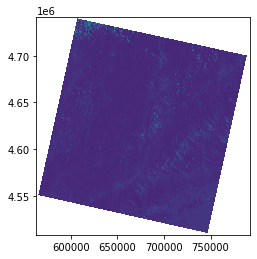

In [14]:
# Visualize one of the image bands
rasterio.plot.show(band4)

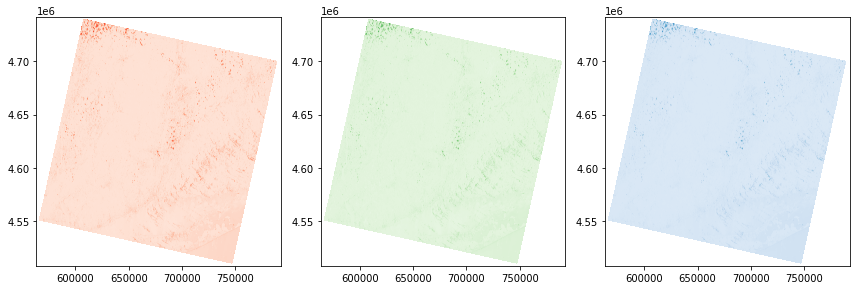

In [21]:
# Plot the R-G-B bands seperately in subplots
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
plot.show(band4, ax=ax1, cmap='Reds')
plot.show(band3, ax=ax2, cmap='Greens')
plot.show(band2, ax=ax3, cmap='Blues')

fig.tight_layout()

In [ ]:
## Stacking the band arrays
# Normalize each band array to range from zero to one,
# and stack the band arrays to produce an rgb composite.

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
band4n = normalize(band4)
band3n = normalize(band3)
band2n = normalize(band2)

print("Normalized bands")
print(band4n.min(), '-', band4n.max(), 'mean:', band4n.mean())
print(band3n.min(), '-', band3n.max(), 'mean:', band3n.mean())
print(band2n.min(), '-', band2n.max(), 'mean:', band2n.mean())

## Save numpy array to raster file
- Save multiple bands to a single raster dataset 

In [30]:
# Create an RGB composite
# To render these raster datasets together to create a color composite,
# each band needs to be contained within a single raster dataset

# Open a new raster file, and initialize with the same parameters from the L8 scene
# (use any band from the scene to get the parameters)
# the following are the major parameters used to write a new raster file
rgbRaster = rasterio.open('./data/LandsatRGB.tiff', 'w', driver='GTiff',
                         width=band4.width, height = band4.height,
                         count= 3,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0],
                         nodata = -9999)

# Write each band to the raster file
rgbRaster.write(band4.read(1), 1) # write the red band
rgbRaster.write(band3.read(1), 2) # green
rgbRaster.write(band2.read(1), 3) # blue

# Close the raster file
rgbRaster.close()

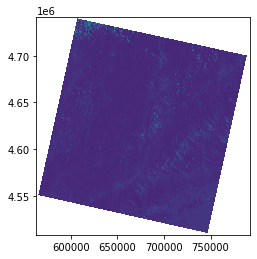

In [33]:
# Plot the RGB raster (rasterio only plots one band, does not mean that the output raster is wrong)
# View the rgb raster in QGIS, TuiView, ENVI, or another raster viewer
src = rasterio.open("./data/LandsatRGB.tiff", "r", count=3)
rasterio.plot.show(src)

In [35]:
# Create an NIR-R-G composite

# Open a new raster file, and initialize with the same parameters from the L8 scene
# (use any band from the scene to get the parameters)
# the following are the major parameters used to write a new raster file
NIR_R_G_raster = rasterio.open('./data/LandsatNIR_RG.tif', 'w', driver='GTiff',
                         width=band4.width, height = band4.height,
                         count= 3,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0],
                         nodata = -9999)

# Write each band to the raster file
NIR_R_G_raster.write(band5.read(1), 1) # write the red band
NIR_R_G_raster.write(band3.read(1), 2) # green
NIR_R_G_raster.write(band2.read(1), 3) # blue

# Close the raster file
NIR_R_G_raster.close()

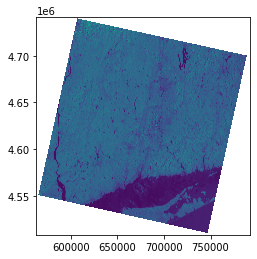

In [38]:
# Plot the NIR-R-G raster (remember, rasterio only plots one band!)
# View the NIR-R-G raster composite in QGIS, TuiView, or another raster viewer
src_nir = rasterio.open("./data/LandsatNIR_RG.tif", "r", count=3)
rasterio.plot.show(src_nir)

## Histogram of the Raster Data

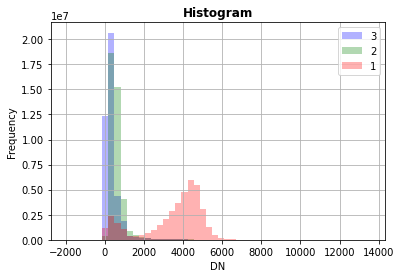

In [40]:
# Histogram
trueColor = rasterio.open("./data/LandsatNIR_RG.tif")
rasterio.plot.show_hist(trueColor, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype="stepfilled", title="Histogram")